# Todo list:

1. Calibrate the DC value of the accelerometer
2. How far away are we from detecting earths rotation?
3. measure covariances of all the sensors
4. Understand why the MARG is worse than IMU: tune the gains
5. include a kalman-filtered gps sensor

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import numpy as np
from scipy import fft
from numpy import exp,sin,cos,pi
from numpy.linalg import norm
#from pyquaternion import Quaternion 
from scipy.optimize import minimize

from utils import *

import ahrs
from ahrs import Quaternion
from geomag.geomag import GeoMag


In [2]:
## Geomagnetic data
## coordinates at hillegas x parker in berkeley
lat=37.864
lon=-122.256
gm=GeoMag().GeoMag(lat,lon)
gm.dec
gm.dip

61.3090304637369

In [3]:
## Read in the data
raw_dat=load_endaq_log("data/accel_cal_")

#Pull out the magnetometer data in numpy form
dfMag=raw_dat['mag']
mag=dfMag.to_numpy()
# Get the magnetometer time series in seconds
ts=dfMag.index.to_numpy(dtype=np.float32)/1e9
ts=ts-ts[0]

# Synch the gyro to the magnetometer, convert to radians/s
gyro=(pi/180)*synchronize_series(raw_dat['gyro'],ref=dfMag).to_numpy()

#Sync the accelerometer to the gyro
#the 8g accelerometer is by far the best.
acc=   synchronize_series(raw_dat['acc8'],ref=dfMag).to_numpy()
#accIMU= synchronize_series(raw_dat['accIMU'],ref=dfMag).to_numpy()
#acc16=  synchronize_series(raw_dat['acc16'],ref=dfMag).to_numpy()

Successfully loaded  Ch80_8g_DC_Acceleration.csv
Successfully loaded  Ch32_16g_DC_Acceleration.csv
Successfully loaded  Ch43_IMU_Acceleration.csv
Successfully loaded  Ch47_Rotation.csv
Successfully loaded  Ch51_IMU_Magnetic_Field.csv


TypeError: float() argument must be a string or a number, not 'Quaternion'

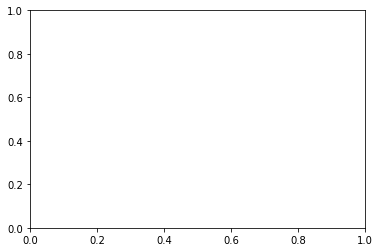

In [5]:
#### Minimal AHRS example, no position estimation
_,QMARG=apply_ahrs(gyro,acc,mag,ts,filter="MARG")
_,QIMU=apply_ahrs(gyro,acc,mag,ts,filter="IMU")
    
## Plot the quaternions from the two different methods
## This was working before, I don't know what broke...
ahrs.utils.plot_quaternions(QMARG)
ahrs.utils.plot_quaternions(QIMU)


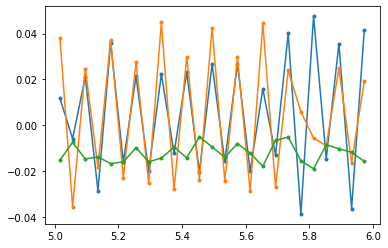

In [6]:
#### Minimal AHRS-Dead reckoning example
state,ACC_LAB,QIMU=apply_ahrs(gyro,acc,mag,ts,position=True)
    
## Inspect the dead-reckoning position estimate
tmax=6
tmin=5
mask=(ts<tmax) & (ts>tmin)
plt.plot(ts[mask],state[mask,0],marker=".")
plt.plot(ts[mask],state[mask,1],marker=".")
plt.plot(ts[mask],state[mask,2],marker=".")